##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 概率 PCA

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/probability/examples/Probabilistic_PCA"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Probabilistic_PCA.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Probabilistic_PCA.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Probabilistic_PCA.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

概率主成分分析 (PCA) 是一种降维技术，它在较低维度的隐空间中分析数据（[Tipping 和 Bishop，1999 年](#1)），通常在数据中缺少值或者进行多维标度时使用。

## 导入

In [ ]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

## 模型

假设有一个由 $N$ 个数据点组成的数据集 $\mathbf{X} = {\mathbf{x}_n}$，其中每个数据点均为 $D$ 维，$\mathbf{x}_n \in \mathbb{R}^D$。我们的目标是使用较低维度 ($K &lt; D$) 在隐变量 $\mathbf{z}_n \in \mathbb{R}^K$ 下表示每个 $\mathbf{x}_n$。主轴集 $\mathbf{W}$ 将隐变量与该数据相关联。

具体来说，我们假定每个隐变量为正态分布，

$$ \begin{equation*} \mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}). \end{equation*} $$

通过投影，生成相应的数据点，

$$ \begin{equation*} \mathbf{x}_n \mid \mathbf{z}_n \sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}), \end{equation*} $$

其中，矩阵 $\mathbf{W}\in\mathbb{R}^{D\times K}$ 称为主轴。在概率 PCA 中，我们通常关注的是估计主轴 $\mathbf{W}$ 和噪声项 $\sigma^2$。

概率 PCA 概括了经典 PCA。对隐变量进行边缘化处理后，每个数据点的分布为

$$ \begin{equation*} \mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}). \end{equation*} $$

当噪声的协方差变得无穷小 ($\sigma^2 \to 0$) 时，经典 PCA 就是概率 PCA 的特例。

我们按如下所述设置模型。在我们的分析中，我们假定 $\sigma$ 已知，并且不将 $\mathbf{W}$ 点估计为模型参数，而是对其使用先验，以便推断主轴的分布。我们将模型表示为 TFP JointDistribution，具体来说，我们将使用 [JointDistributionCoroutineAutoBatched](https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/JointDistributionCoroutineAutoBatched)。

In [ ]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w")
  z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z")
  x = yield tfd.Normal(loc=tf.matmul(w, z),
                       scale=stddv_datapoints,
                       name="x")

In [ ]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

## 数据

我们可以使用模型从联合先验分布中抽样，从而生成数据。

In [ ]:
actual_w, actual_z, x_train = model.sample()

print("Principal axes:")
print(actual_w)

Principal axes:
tf.Tensor(
[[ 2.2801023]
 [-1.1619819]], shape=(2, 1), dtype=float32)


我们呈现数据集。

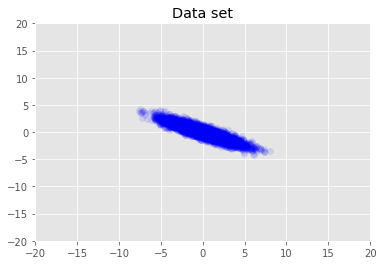

In [ ]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

## 最大后验概率推断

首先，我们搜索隐变量中尽可能增加后验概率密度的点估计值。这称为最大后验概率 (MAP) 推断，操作方法是计算尽可能增加后验密度 $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}) \propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$ 的 $\mathbf{W}$ 和 $\mathbf{Z}$ 的值。


In [ ]:
w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, z),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

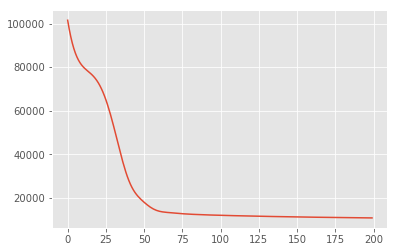

In [ ]:
plt.plot(losses)

我们可以使用该模型为 $\mathbf{W}$ 和 $\mathbf{Z}$ 抽取已推断值的数据，并与我们作为条件的实际数据集进行对比。

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.9135954],
       [-1.4826864]], dtype=float32)>


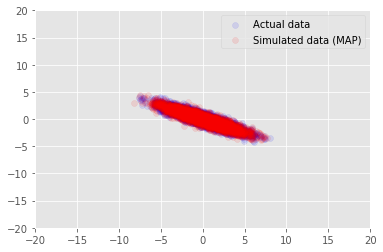

In [ ]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## 变分推断

可以使用 MAP 查找后验分布的模式（或其中一种模式），但 MAP 不提供关于该模式的任何其他见解。接下来，我们使用变分推断，在该推断中，使用由 $\boldsymbol{\lambda}$ 参数化的变分分布 $q(\mathbf{W}, \mathbf{Z})$ 来逼近后验分布 $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X})$。目的是查找变分参数 $\boldsymbol{\lambda}$，这些参数会*尽可能减少* q 与后验之间的 KL 散度 $\mathrm{KL}(q(\mathbf{W}, \mathbf{Z}) \mid\mid p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}))$，或者相当于*尽可能增加*证据下限 $\mathbb{E}_{q(\mathbf{W},\mathbf{Z};\boldsymbol{\lambda})}\left[ \log p(\mathbf{W},\mathbf{Z},\mathbf{X}) - \log q(\mathbf{W},\mathbf{Z}; \boldsymbol{\lambda}) \right]$。


In [ ]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())
def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.4168603],
       [-1.2236133]], dtype=float32)>
Standard Deviation:
<TransformedVariable: dtype=float32, shape=[2, 1], fn="softplus", numpy=
array([[0.0042499 ],
       [0.00598824]], dtype=float32)>


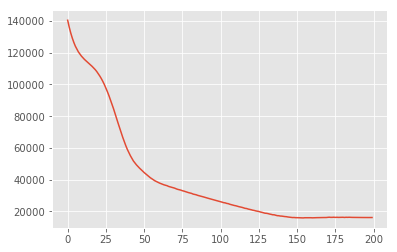

In [ ]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

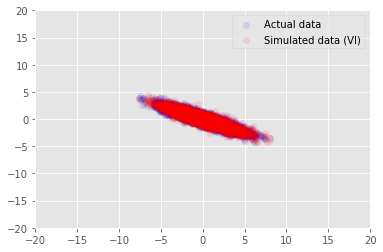

In [ ]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## 致谢

本教程最初用 Edward 1.0编写（[源代码](https://github.com/blei-lab/edward/blob/master/notebooks/probabilistic_pca.ipynb)）。我们在此向编写和修订该版本的所有贡献者表示感谢。

#### 参考文献

<a name="1"></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, 61(3): 611-622, 1999.